<a href="https://colab.research.google.com/github/pratchayapron/229351-StatisticalLearning-or-Statistical-Learning-Labs/blob/main/229351_LAB11_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [ ]:
# ONLY RUN THIS WHEN THERE IS AN ERROR
!pip install --user statsmodels==0.13.1

In [36]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-22 17:41:46--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.44.200, 172.66.47.56, 2606:4700:310c::ac42:2cc8, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.44.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.01s   

2025-09-22 17:41:46 (9.54 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [37]:
!pip3 install pmdarima

In [38]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA


In [39]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
def parser(dates):
  return pd.to_datetime(dates, format='%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date',
                                        date_parser=parser)

data.head()

/tmp/ipython-input-2681058149.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],


,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [40]:
y = data['MaxTemp'].resample("M").mean()
display(y.head())

/tmp/ipython-input-3553463788.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387


In [41]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [42]:
train = y[:-24]
test = y[-24:]

print(test)

Date
2017-08-31    32.764516
2017-09-30    33.140000
2017-10-31    32.158065
2017-11-30    31.616667
2017-12-31    29.229032
2018-01-31    30.048387
2018-02-28    33.253571
2018-03-31    35.674194
2018-04-30    35.900000
2018-05-31    34.648387
2018-06-30    33.066667
2018-07-31    32.000000
2018-08-31    32.258065
2018-09-30    33.506667
2018-10-31    32.864516
2018-11-30    32.336667
2018-12-31    30.229032
2019-01-31    30.622581
2019-02-28    34.564286
2019-03-31    37.051613
2019-04-30    39.716667
2019-05-31    37.680645
2019-06-30    35.466667
2019-07-31    34.070968
Freq: ME, Name: MaxTemp, dtype: float64


In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define a list of different SARIMA orders to test
orders = [
    ((1, 0, 1), (1, 0, 1, 12)),
    ((1, 1, 1), (1, 1, 1, 12)),
    ((0, 1, 1), (0, 1, 1, 12)),
    ((1, 1, 0), (1, 1, 0, 12)),
    ((0, 0, 0), (1, 0, 0, 12)),
    ((0, 0, 0), (0, 0, 0, 0))
]

results = []

for order in orders:
    try:
        model = SARIMAX(train, order=order[0], seasonal_order=order[1], enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)
        error = rmse(test, predictions)
        results.append((order, error))
        print(f"Order: {order}, RMSE: {error}")
    except Exception as e:
        print(f"Error fitting model for order {order}: {e}")
        results.append((order, float('inf'))) # Append infinity for failed models

# Sort results by RMSE to find the best model
results.sort(key=lambda x: x[1])

best_order = results[0][0]
best_rmse = results[0][1]

print(f"\nBest SARIMA order: {best_order} with RMSE: {best_rmse}")

Order: ((1, 0, 1), (1, 0, 1, 12)), RMSE: 0.8898959916103519
Order: ((1, 1, 1), (1, 1, 1, 12)), RMSE: 0.9124408577519072
Order: ((0, 1, 1), (0, 1, 1, 12)), RMSE: 1.1348310595340438
Order: ((1, 1, 0), (1, 1, 0, 12)), RMSE: 1.4309359046621932
Order: ((0, 0, 0), (1, 0, 0, 12)), RMSE: 1.279543953265398
Order: ((0, 0, 0), (0, 0, 0, 0)), RMSE: 33.5856910851065

Best SARIMA order: ((1, 0, 1), (1, 0, 1, 12)) with RMSE: 0.8898959916103519


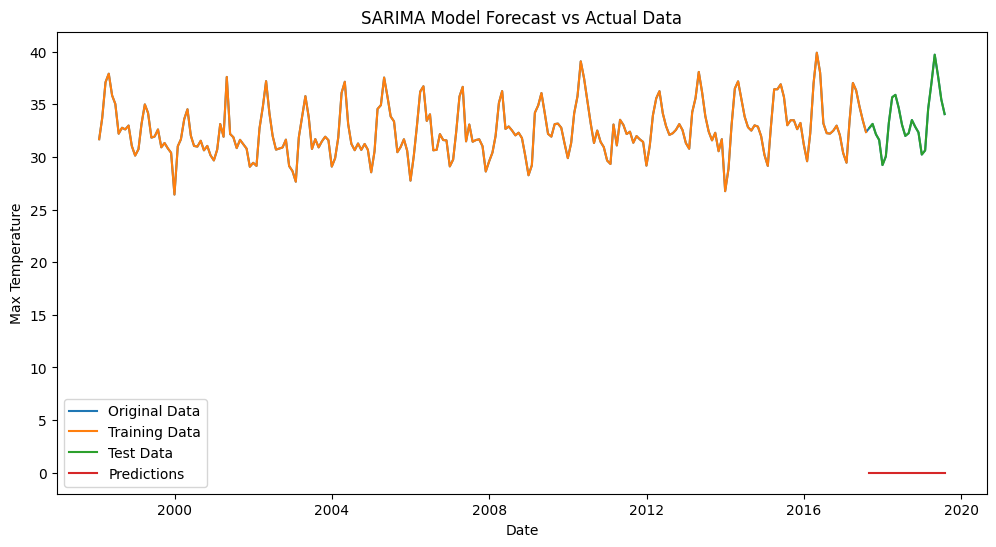

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(y, label='Original Data')
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.title('SARIMA Model Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Max Temperature')
plt.show()